# Прикладные задачи анализа данных

## Домашнее задание 4

В этой работе мы будем решать задачу рекомендаций музыки. Для этого мы реализуем метод коллаборативной фильтрации и модель со скрытыми переменными, сравним их между собой и попытаемся сделать выводы. Во всех заданиях разрешается переписывать код по своему усмотрению, предложенные шаблоны несут лишь рекомендательный характер.

In [162]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List
import time
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [163]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [164]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (1 балл).** Реализуйте метрику $MAP@k$.

In [165]:
def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
    # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
    ans = 0.0
    for rel, pred in zip(relevant, predicted):
        rel_set = set(rel)
        n_rel = len(rel_set)
        if n_rel == 0:
            continue
        hits = 0
        score = 0.0
        for i, p in enumerate(pred[:k], 1):
            if p in rel_set:
                hits += 1
                score += hits / i
        ans += score / min(k, n_rel)
    return ans / len(relevant)

In [166]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [167]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [168]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [169]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [170]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [171]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [172]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [173]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [174]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**Задание 2 (1 балл).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [175]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.

    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []

        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        test_preds = self.remove_train_items(
            np.array([self.recommend(u) for u in range(self.n_users)], dtype=int),
            k
        )

        return test_preds[test_users]

## Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать две метрики:

1. Корреляция Пирсона $$s(u, v) = \frac{\sum_{i \in I_u \cap I_v} r_{ui}r_{vi}}{\sqrt{\sum_{i \in I_u} r_{ui} ^2}\sqrt{\sum_{i \in I_v} r_{vi}^2}} $$

2. Мера Жаккара

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Корреляция Пирсона немного видоизменена, чтобы подходить под нашу задачу.


Во всех формулах
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.1 (1 балл).** Реализуйте функцию подсчета корреляции Пирсона.

**Задание 3.2 (1 балл).** Реализуйте функцию подсчета меры Жаккара.

Функции принимают матрицу оценок и вектор оценок пользователя $u$ и возвращают вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [176]:
def pearson(ratings, user_vector):
    inter  = ratings @ user_vector
    denom  = np.sqrt(user_vector.sum() * ratings.sum(axis=1))
    return np.divide(inter, denom, out=np.zeros_like(inter, float), where=denom > 0)


def jaccard(ratings, user_vector):
    inter  = ratings @ user_vector
    union  = user_vector.sum() + ratings.sum(axis=1) - inter
    return np.divide(inter, union, out=np.zeros_like(inter, float), where=union > 0)

**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок.


In [177]:
class User2User(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)
        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        return self.similarity_func(self.R, user_vector)

    def recommend(self, uid: int):
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        sim = self.similarity(self.R[uid])
        sim[uid] = 0
        sim[sim <= self.alpha] = 0
        denom = np.abs(sim).sum()
        scores = np.zeros(self.n_items) if denom == 0 else (sim @ self.R) / denom
        return np.argsort(-scores)

**Задание 5 (1 балл).** Постройте графики зависимости значений $MAP@k$ от разных $k$ для обоих функций похожести, сравните их между собой, а также с предсказаниями случайного алгоритма и сделайте выводы.

<ipython-input-175-1662661258>:26: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]


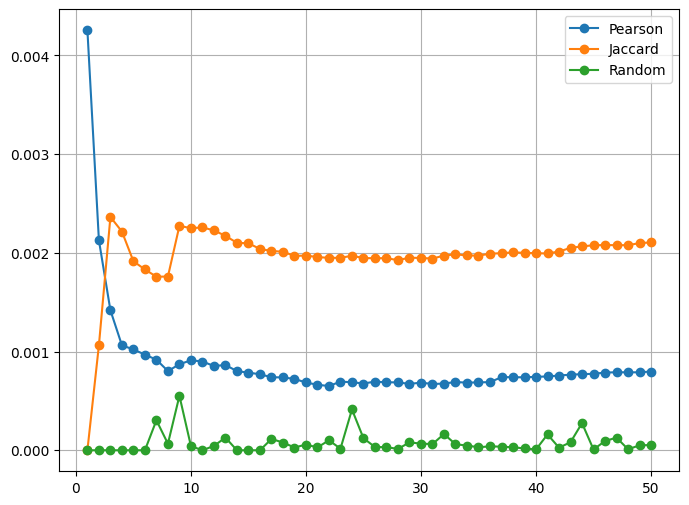

In [178]:
k_vals = list(range(1, 51))

p_model = User2User(train_ratings, pearson)
j_model = User2User(train_ratings, jaccard)

scores = {'Pearson': [], 'Jaccard': [], 'Random': []}

for k in k_vals:
    p_preds = p_model.get_test_recommendations(k).tolist()
    j_preds = j_model.get_test_recommendations(k).tolist()

    r_preds = []
    for uid in test_users:
        train_items = train_ratings[train_ratings['userId'] == uid]['trackId'].values
        pool = np.setdiff1d(np.arange(p_model.n_items), train_items)
        if len(pool) >= k:
            r_preds.append(np.random.choice(pool, k, replace=False).tolist())
        else:
            r_preds.append(np.random.choice(pool, k, replace=True).tolist())

    scores['Pearson'].append(mapk(test_relevant, p_preds, k))
    scores['Jaccard'].append(mapk(test_relevant, j_preds, k))
    scores['Random'].append(mapk(test_relevant, r_preds, k))

plt.figure(figsize=(8, 6))
for name, vals in scores.items():
    plt.plot(k_vals, vals, marker='o', label=name)
plt.legend()
plt.grid(True)
plt.show()


Худший показатель у случайных рекоммендаций.\
Вначале по метрике MAP@k лучше показывает себя корреляции Пирсона\
Далее лидирует мера Жакара


**Задание 6 (1.5 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

In [179]:
# your code here: ‿︵‿︵ヽ(°□° )ノ︵‿︵‿
def pearson_sparse(ratings_csr, user_vec_csr):
    inter  = (ratings_csr @ user_vec_csr.T).toarray().ravel()
    denom  = np.sqrt(user_vec_csr.nnz * ratings_csr.getnnz(axis=1))
    return np.divide(inter, denom, out=np.zeros_like(inter, dtype=float), where=denom > 0)


def jaccard_sparse(ratings_csr, user_vec_csr):
    inter  = (ratings_csr @ user_vec_csr.T).toarray().ravel()
    union  = user_vec_csr.nnz + ratings_csr.getnnz(axis=1) - inter
    return np.divide(inter, union, out=np.zeros_like(inter, dtype=float), where=union > 0)



In [180]:
class User2UserSparse(User2User):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings, similarity_func)
        self.R = scs.csr_matrix(self.R)

До

In [181]:

start = time.time()
p = User2User(train_ratings, similarity_func = pearson).get_test_recommendations(20)
print(f'Pearson: {time.time() - start: .2f} sec')

start = time.time()
User2User(train_ratings, similarity_func = jaccard).get_test_recommendations(20)
print(f'Jaccard: {time.time() - start: .2f} sec')



<ipython-input-175-1662661258>:26: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]


Pearson:  11.31 sec
Jaccard:  9.84 sec


После

In [182]:
start = time.time()
p = User2UserSparse(train_ratings, similarity_func = pearson_sparse).get_test_recommendations(20)
print(f'Pearson: {time.time() - start: .2f} sec')

start = time.time()
j = User2UserSparse(train_ratings, similarity_func = jaccard_sparse).get_test_recommendations(20)
print(f'Jaccard: {time.time() - start: .2f} sec')

<ipython-input-175-1662661258>:26: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]


Pearson:  1.20 sec
Jaccard:  0.95 sec


Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [183]:
user_id = np.random.randint(0, p_model.n_users)

In [184]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
234,Wind Of Change,['Scorpions']
297,Fuck Them All,['Mylène Farmer']
357,Inside Out,['Bryan Adams']
369,Ameno,['Era']
707,Sweet Dreams (Are Made of This),['Marilyn Manson']
805,Zombie,['The Cranberries']
1011,Wish I Had An Angel,['Nightwish']
1013,Over The Hills And Far Away,['Nightwish']
1014,Sleeping Sun,['Nightwish']
1018,Nemo,['Nightwish']


In [185]:
preds = p_model.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

<ipython-input-175-1662661258>:26: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]


Predicted tracks:


,name,artists
46533,Life,['Zivert']
24500,Way Down We Go,['KALEO']
33436,Believer,['Imagine Dragons']
49023,Грустный дэнс,"['Artik & Asti', 'Артём Качер']"
2814,Numb,['Linkin Park']
1019,It's My Life,['Bon Jovi']
11493,The Show Must Go On,['Queen']
805,Zombie,['The Cranberries']
53422,Dance Monkey,['Tones And I']
35656,I Got Love,"['Miyagi & Эндшпиль', 'Рем Дигга']"


In [186]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
66845,Ты со мной,"['Lina Lee', 'Ваня Дмитриенко']"
66948,Пройдёшь,"['Bahh Tee', 'Turken']"
66960,ЛА ЛА ЛА,['Клава Кока']
67017,С кем ты зависаешь?,['kavabanga Depo kolibri']
67018,2 человека,['#2Маши']
67037,Полюбил,['Валерий Меладзе']
67040,Август - это ты,['MOT']
67075,Манекен,['ВИА ГРА']
67083,Волей-неволей,['Elvira T']
67090,Летний Снег,['Jah Khalib']


### Часть 2. Модель со скрытыми переменными

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно.

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

**Задание 7 (1.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Вспомните формулы обновления и поясните их:

**SGD:**

Ответ
$$p_{uk} := p_{uk} + \gamma \bigl( e_{ui}\, q_{ik} - \lambda\, p_{uk} \bigr)$$
$$q_{ik} := q_{ik} + \gamma \bigl( e_{ui}\, p_{uk} - \lambda\, q_{ik} \bigr).$$
где $$
e_{ui} = r_{ui} - \langle p_u, q_i \rangle
$$
**ALS:**

Ответ
$$ p_u = (\sum_{i \in I_u}q_i q_i^T + \lambda I_d)^{-1} \sum_{i \in I_u} r_{ui}q_i $$

$$ q_i = (\sum_{u \in U_i}p_u p_u^T + \lambda I_d)^{-1} \sum_{u \in U_i} r_{ui} p_u $$


**Задание 8 (2 балла).** А теперь реализуйте методы оптимизации параметров для обоих алгоритмов.

In [187]:
class HiddenVars(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd'):
        super().__init__(ratings)
        self.dim = dim

        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.lr = 0.0003
        self.lamb = 0.01

    def fit(self, num_iters=5):
        for epoch in tqdm(range(num_iters)):

            if self.mode == 'sgd':
                # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
                idx = np.random.permutation(len(self.ratings))

                for pos in idx:
                    u = self.ratings.iat[pos, 0]
                    i = self.ratings.iat[pos, 1]
                    r_ui = 1.0
                    pred = self.P[u] @ self.Q[i]
                    err  = r_ui - pred
                    self.P[u] += self.lr * ( err * self.Q[i] - self.lamb * self.P[u] )
                    self.Q[i] += self.lr * ( err * self.P[u] - self.lamb * self.Q[i] )

            elif self.mode == 'als':
                # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
                I = np.eye(self.dim)

                QtQ = self.Q.T @ self.Q

                for u in range(self.n_users):
                    idx_u = self.R[u].nonzero()[0]
                    if idx_u.size == 0:
                        continue
                    Q_u = self.Q[idx_u]
                    A   = QtQ + self.lamb * I
                    b   = Q_u.sum(axis=0)
                    self.P[u] = np.linalg.solve(A, b)

                PtP = self.P.T @ self.P

                for i in range(self.n_items):
                    idx_i = self.R[:, i].nonzero()[0]
                    if idx_i.size == 0:
                        continue
                    P_i = self.P[idx_i]
                    A   = PtP + self.lamb * I
                    b   = P_i.sum(axis=0)
                    self.Q[i] = np.linalg.solve(A, b)

    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T

        return np.argsort(pred_rating)[::-1]

**Задание 9 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

P.S. Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

P.P.S. Методу LFM свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

In [188]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪
model = HiddenVars(train_ratings, mode='als')
model.fit()
model2 = HiddenVars(train_ratings, mode='sgd')
model2.fit()
scores_new = scores.copy()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

<ipython-input-175-1662661258>:26: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]


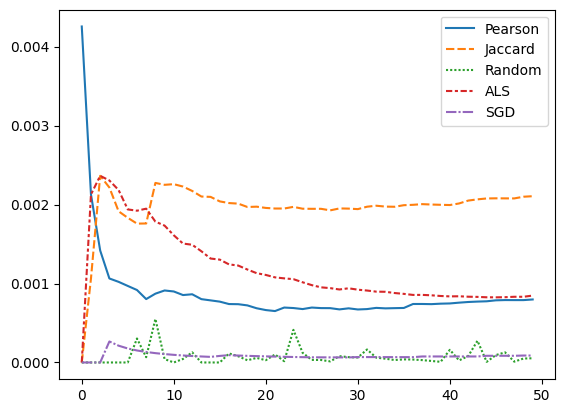

In [189]:
pred = model.get_test_recommendations(50)
pred2 = model2.get_test_recommendations(50)
scores_new['ALS'] =[]
scores_new['SGD'] =[]
for k in range(1, 51):

    scores_new['ALS'].append(mapk(test_relevant, pred, k))
    scores_new['SGD'].append(mapk(test_relevant, pred2, k))


sns.lineplot(data = pd.DataFrame(scores_new));

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [190]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = model.Q @ model.Q[example_trackId]
preds = preds / np.sqrt((model.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [191]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
2058,Последний герой,['КИНО'],0.746023
5517,Варвара,['Би-2'],0.705289
16224,Пока горит свеча,['Машина времени'],0.686584
5872,Я свободен,['Кипелов'],0.683132
16637,Zodiac,['Zodiac'],0.678178
5153,Stormbringer,['Deep Purple'],0.678178
9689,Bicycle Race,['Queen'],0.678178
11493,The Show Must Go On,['Queen'],0.677439
2179,Восьмиклассница,['КИНО'],0.675511
